In [1]:
!pwd
import sys
sys.executable

/c/Users/shingo/jupyter_notebook/stock_work/03.stock_repo/value_at_risk


'C:\\Users\\shingo\\Anaconda3\\envs\\stock\\python.exe'

# PythonでのVaR(Value at Risk)のモンテカルロシミュレーション
- https://medium.com/quaintitative/monte-carlo-simulation-of-value-at-risk-in-python-c4da3ffe0f18

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,2148.18,2191.67,2146.30,2175.60,765200
2010-01-05,2212.46,2212.46,2124.54,2136.84,2051394
2010-01-06,2136.84,2179.39,2129.28,2155.75,2500571
2010-01-07,2148.18,2155.75,2099.96,2113.20,3157788
2010-01-08,2132.12,2147.25,2097.14,2117.91,3035736


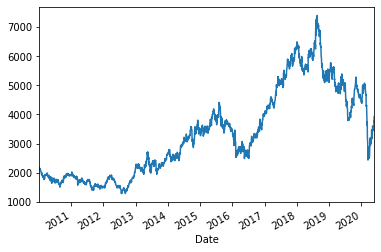

In [2]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats
import matplotlib.pyplot as plt
import pandas_datareader.data as web

# pandas_datareader でスズキの株価取得
code = '7269.JP'
df = web.DataReader(code, 'stooq')
df = df.sort_index()
display(df.head())

df['Close'].plot()
plt.show()

Date
2010-01-04         NaN
2010-01-05   -0.017816
2010-01-06    0.008850
2010-01-07   -0.019738
2010-01-08    0.002229
Name: Close, dtype: float64

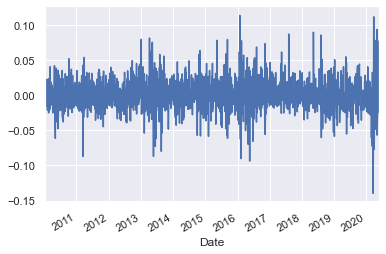

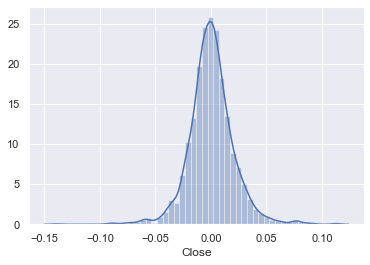

In [3]:
import seaborn as sns
sns.set() # seabornのスタイルで描画する

# 収益率計算
rets_1 = (df['Close'] / df['Close'].shift(1)) - 1  # 基準を0にするために-1している
display(rets_1.head())

rets_1.plot()
plt.show()

sns.distplot(rets_1)
plt.show()

### 正規分布になる収益率からモンテカルロシミュレーションで「信頼水準99%のVaR」を計算する

In [4]:
def sim_montecarlo_var99(return_rates):
    """
    正規分布になる収益率から
    モンテカルロシミュレーション(正規分布乱数発生させて疑似的に値を生成する)で
    「信頼水準99%のVaR」を計算する
    """
    import numpy as np
    
    np.random.seed(42)
    n_sims = 1000000
    
    mean = np.mean(return_rates)
    std = np.std(return_rates)
    
    # データから計算した平均と分散の正規分布からランダムに値取り出す
    sim_values = np.random.normal(mean, std, n_sims)  
    
    # シミュレーションして出した値のヒストグラム上での1パーセンタイルの値
    return np.percentile(sim_values, 1)
    
# 収益率計算
rets_1 = (df['Close'] / df['Close'].shift(1)) - 1  # 基準を0にするために-1している

# 実行
var99 = sim_montecarlo_var99(rets_1)

base_price = df.iloc[-1]['Close']  # 最新日付の終値を基準とする
sim_price_per99 = base_price * var99
print(f"Simulated price percentile 99 is {base_price} ± {sim_price_per99: 3f}")

Simulated price percentile 99 is 3924.0 ± -184.614638


## シュミレーション結果より、終値が3924円なら、最大184円程度株価変動することがわかる

In [5]:
std = np.std(rets_1)
Z_99 = stats.norm.ppf(1 - 0.99)  # 正規分布の密度関数
param_price_per99 = base_price * Z_99 * std  # パラメトリック=正規分布仮定したときの分散
hist_price_per99 = base_price * np.percentile(rets_1.dropna(), 1)  # ヒストグラム上での1パーセンタイルの値
print(f"Parametric price percentile 99 is {param_price_per99:.3f}")
print(f"Historical price percentile 99 is {hist_price_per99:.3f}")

Parametric price percentile 99 is -186.026
Historical price percentile 99 is -223.490


## 収益率を正規分布と仮定した場合は、最大184円程度株価変動
## 実際の収益率の分布から1パーセンタイルの値とると、最大223円程度株価変動